# **Стартап, который продаёт продукты питания**

**Цели проекта:**

Разобремся, как ведут себя пользователи нашего мобильного приложения. 
Изучим воронку продаж. Узнаем, как пользователи доходят до покупки. Сколько пользователей доходит до покупки, а сколько — «застревает» на предыдущих шагах и на каких именно.
Исследуем результаты A/A/B-эксперимента. Дизайнеры захотели поменять шрифты во всём приложении, а менеджеры испугались, что пользователям будет непривычно. Договорились принять решение по результатам A/A/B-теста. Пользователей разбили на 3 группы: 2 контрольные со старыми шрифтами и одну экспериментальную — с новыми. Выясните, какой шрифт лучше.
Сравнение контрольных групп также помогает понять, сколько времени и данных потребуется для дальнейших тестов.

**Описание данных:**

Каждая запись в логе — это действие пользователя, или событие. 

- EventName — название события;

- DeviceIDHash — уникальный идентификатор пользователя;

- EventTimestamp — время события;

- ExpId — номер эксперимента: 246 и 247 — контрольные группы, а 248 — экспериментальная.

**События:**

- MainScreenAppear	- просмотр главного экрана

-	OffersScreenAppear - просмотр каталога товаров

- CartScreenAppear - просмотр корзины

-	PaymentScreenSuccessful	- оплата

-	Tutorial - обучающая страница

**План работы:**

- Загрузим и изучим данные
- Проведем предобработку данных
- Изучим воронку событий
- Проведем A/A/B тестирование и изучим результаты эксперимента

## **Шаг 1. Откроем файл с данными и изучим общую информацию**

In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from scipy import stats as st
from pandas.plotting import register_matplotlib_converters
import warnings
# конвертеры, которые позволяют использовать типы pandas в matplotlib  
register_matplotlib_converters()
import math as mth

In [3]:
try:
    data = pd.read_csv('/content/drive/MyDrive/DA/hw-da/portfolioDA/datasets/logs_exp.csv', sep='\t')
except:
    data = pd.read_csv('/datasets/logs_exp.csv', sep='\t')

In [4]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 244126 entries, 0 to 244125
Data columns (total 4 columns):
 #   Column          Non-Null Count   Dtype 
---  ------          --------------   ----- 
 0   EventName       244126 non-null  object
 1   DeviceIDHash    244126 non-null  int64 
 2   EventTimestamp  244126 non-null  int64 
 3   ExpId           244126 non-null  int64 
dtypes: int64(3), object(1)
memory usage: 7.5+ MB


In [5]:
data.head()

,EventName,DeviceIDHash,EventTimestamp,ExpId
0,MainScreenAppear,4575588528974610257,1564029816,246
1,MainScreenAppear,7416695313311560658,1564053102,246
2,PaymentScreenSuccessful,3518123091307005509,1564054127,248
3,CartScreenAppear,3518123091307005509,1564054127,248
4,PaymentScreenSuccessful,6217807653094995999,1564055322,248


## **Шаг 2. Подготовим данные**

### Заменим названия столбцов на удобные для нас;


In [6]:
data = data.rename(columns = {'EventName': 'Event_Name', 'DeviceIDHash': 'Device_ID', 'EventTimestamp': 'Event_date', 'ExpId': 'Exp_Id'})
data.columns = data.columns.str.lower()

In [7]:
data.head()

,event_name,device_id,event_date,exp_id
0,MainScreenAppear,4575588528974610257,1564029816,246
1,MainScreenAppear,7416695313311560658,1564053102,246
2,PaymentScreenSuccessful,3518123091307005509,1564054127,248
3,CartScreenAppear,3518123091307005509,1564054127,248
4,PaymentScreenSuccessful,6217807653094995999,1564055322,248




---



### Проверьте пропуски, дубликаты и типы данных. Откорректируем, если нужно;



In [8]:
data.isna().sum()

event_name    0
device_id     0
event_date    0
exp_id        0
dtype: int64

Пропусков нет, отлично.

In [9]:
data.duplicated().sum()

413

In [10]:
data = data.drop_duplicates().reset_index(drop=True)
data.duplicated().sum()

0

Дубликаты найдены. Удалим их, чтобы не искажать результаты исследования.



---



### Добавьте столбец даты и времени, а также отдельный столбец дат;

In [11]:
data['date_time'] = pd.to_datetime(data['event_date'], unit='s')
data['date'] = data['date_time'].astype('datetime64[D]')

In [12]:
data.head()

,event_name,device_id,event_date,exp_id,date_time,date
0,MainScreenAppear,4575588528974610257,1564029816,246,2019-07-25 04:43:36,2019-07-25 04:43:36
1,MainScreenAppear,7416695313311560658,1564053102,246,2019-07-25 11:11:42,2019-07-25 11:11:42
2,PaymentScreenSuccessful,3518123091307005509,1564054127,248,2019-07-25 11:28:47,2019-07-25 11:28:47
3,CartScreenAppear,3518123091307005509,1564054127,248,2019-07-25 11:28:47,2019-07-25 11:28:47
4,PaymentScreenSuccessful,6217807653094995999,1564055322,248,2019-07-25 11:48:42,2019-07-25 11:48:42


Изменила тип данных у дат. А также добавила 2 дополнительных столбца с датой и датой и временем.

## **Шаг 3. Изучим и проверим данные**

### Сколько всего событий в логе?


In [13]:
events_log = data.shape[0]
print('Событий в логе:', events_log)

Событий в логе: 243713




---



### Сколько всего пользователей в логе?


In [14]:
device_log = data['device_id'].nunique()
print('Пользователей в логе:', device_log)

Пользователей в логе: 7551




---



### Сколько в среднем событий приходится на пользователя?


In [15]:
print('Событий на пользователя:', round(data.shape[0]/data['device_id'].nunique()))

Событий на пользователя: 32


In [16]:
events_count = data.groupby('device_id').agg(event_count = ('event_name', 'count')).reset_index()
events_count['event_count'].describe()

count    7551.000000
mean       32.275593
std        65.154219
min         1.000000
25%         9.000000
50%        20.000000
75%        37.000000
max      2307.000000
Name: event_count, dtype: float64

Среднее количество событий на пользователя - 32. Однако есть выбросы - самое большое количество событий на пользователя - 2307, медиана - 19. Но на результат исследования это не должно повлиять.



---



In [17]:
diff = data.groupby('device_id').agg({'exp_id':'nunique'}).query('exp_id > 1').reset_index()
diff

,device_id,exp_id


Тут я проверила нет ли пересечений пользователей в разных группах. Их не оказалось, что хорошо для чистоты эксперимента.

### Данными за какой период вы располагаете? Найдите максимальную и минимальную дату. Постройте гистограмму по дате и времени. Можно ли быть уверенным, что у вас одинаково полные данные за весь период? Технически в логи новых дней по некоторым пользователям могут «доезжать» события из прошлого — это может «перекашивать данные». Определите, с какого момента данные полные и отбросьте более старые. Данными за какой период времени вы располагаете на самом деле?


In [18]:
min_date = data['date_time'].min()
max_date = data['date_time'].max()
print('Начальная дата:', min_date)
print('Конечная дата:', max_date)

Начальная дата: 2019-07-25 04:43:36
Конечная дата: 2019-08-07 21:15:17


In [19]:
data['date_time'].describe()

<ipython-input-19-a11ac97bfc2c>:1: FutureWarning: Treating datetime data as categorical rather than numeric in `.describe` is deprecated and will be removed in a future version of pandas. Specify `datetime_is_numeric=True` to silence this warning and adopt the future behavior now.
  data['date_time'].describe()


count                  243713
unique                 176654
top       2019-08-01 14:40:35
freq                        9
first     2019-07-25 04:43:36
last      2019-08-07 21:15:17
Name: date_time, dtype: object

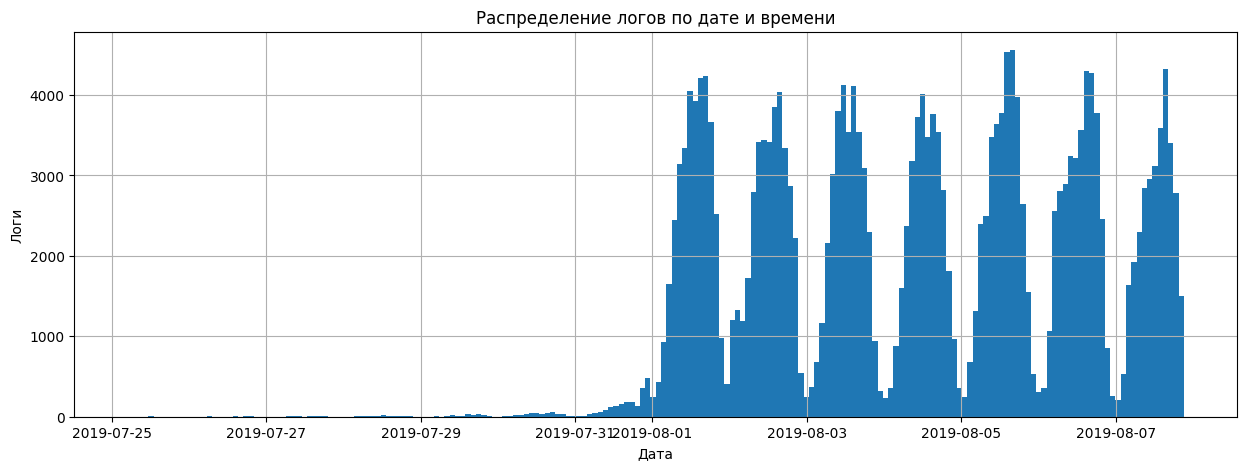

In [20]:
plt.title('Распределение логов по дате и времени')
data['date_time'].hist(bins=200, figsize=(15, 5))
plt.ylabel("Логи")
plt.xlabel("Дата")
plt.show()

Гистограмма показывает, что с 25.07 по 1.08 очень небольшие показатели количества логов. Скорее всего, это "доезжающие" данные, которые нам не нужны. Для чистоты эксперимента - оставим данные с 1.08 по 7.08.

In [21]:
old_date_time = data['date_time']
data = data[data['date_time'] >= '2019-08-01']

In [22]:
data['date_time'].describe()

<ipython-input-22-a11ac97bfc2c>:1: FutureWarning: Treating datetime data as categorical rather than numeric in `.describe` is deprecated and will be removed in a future version of pandas. Specify `datetime_is_numeric=True` to silence this warning and adopt the future behavior now.
  data['date_time'].describe()


count                  240887
unique                 174044
top       2019-08-01 14:40:35
freq                        9
first     2019-08-01 00:07:28
last      2019-08-07 21:15:17
Name: date_time, dtype: object

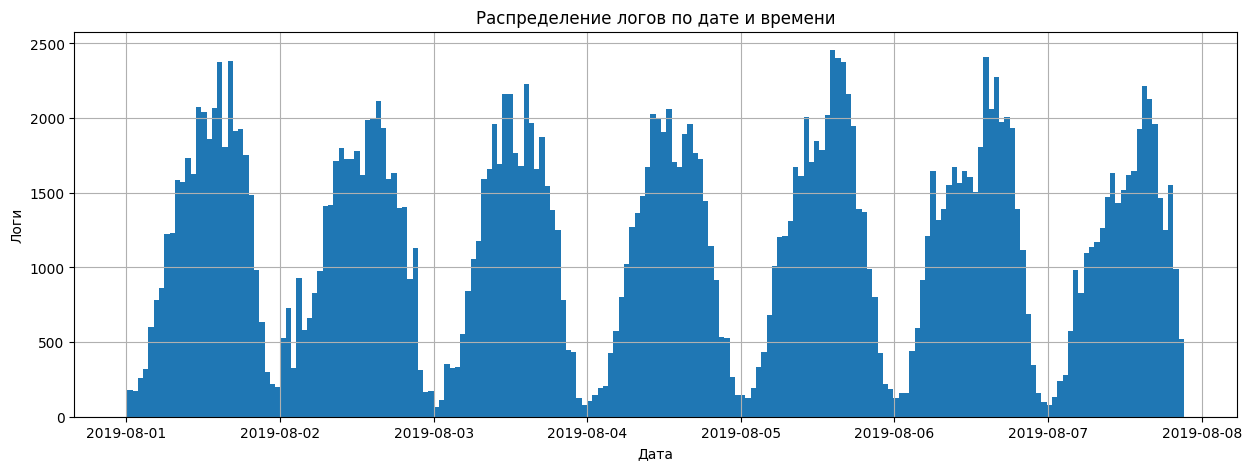

In [23]:
plt.title('Распределение логов по дате и времени')
data['date_time'].hist(bins=200, figsize=(15, 5))
plt.ylabel("Логи")
plt.xlabel("Дата")
plt.show()

Теперь мы видим читые данные по количеству логов. Будем использовать эти данные.



---



### Много ли событий и пользователей вы потеряли, отбросив старые данные?


In [24]:
cl_events_log = data.shape[0]
cl_device_log = data['device_id'].nunique()

In [25]:
print('Потерянные события, в результате отброса старых дат:', cl_events_log - events_log,'из:', events_log)
print('Потерянные пользователи, в результате отброса старых дат:', cl_device_log - device_log,'из:', device_log)

Потерянные события, в результате отброса старых дат: -2826 из: 243713
Потерянные пользователи, в результате отброса старых дат: -17 из: 7551


In [26]:
print('Потерянных событий:',  round((cl_events_log - events_log)/events_log * 100, 2), '%')
print('Потерянных пользователей:', round((cl_device_log - device_log)/device_log * 100, 2), '%')

Потерянных событий: -1.16 %
Потерянных пользователей: -0.23 %


Потерянные события в пределах нормы, оставляем так.



---



### Проверьте, что у вас есть пользователи из всех трёх экспериментальных групп.

In [27]:
data.groupby('exp_id').agg({'device_id': 'nunique'})

,device_id
exp_id,
246,2484
247,2513
248,2537


3 группы есть, количество пользователей немного различаются.

## **Шаг 4. Изучим воронку событий**

### Посмотрите, какие события есть в логах, как часто они встречаются. Отсортируйте события по частоте.


In [28]:
events = (data.groupby('event_name').agg({'device_id': 'count'}).reset_index().sort_values(by='device_id', ascending=False))
events = events.rename(columns={'device_id' : 'events_total'})
events

,event_name,events_total
1,MainScreenAppear,117328
2,OffersScreenAppear,46333
0,CartScreenAppear,42303
3,PaymentScreenSuccessful,33918
4,Tutorial,1005


Мы видим, что наиболее частые события - посещение главного экрана, что логично. Далее идет просмотр каталога и корзины. В конце - оплата и обучающий экран.



---



### Посчитайте, сколько пользователей совершали каждое из этих событий. Отсортируйте события по числу пользователей. Посчитайте долю пользователей, которые хоть раз совершали событие.


In [29]:
dev_events = (data.groupby('event_name').agg({'device_id': 'nunique'}).reset_index())
dev_events = dev_events.rename(columns={'device_id' : 'device_total'}).sort_values(by='device_total', ascending=False)
dev_events['perc'] = round(dev_events['device_total'] / data['device_id'].nunique() * 100, 2)
dev_events

,event_name,device_total,perc
1,MainScreenAppear,7419,98.47
2,OffersScreenAppear,4593,60.96
0,CartScreenAppear,3734,49.56
3,PaymentScreenSuccessful,3539,46.97
4,Tutorial,840,11.15


Тут последовательность аналогичная. Видим, что события у уникальных пользователей имеют такую же последовательность. 



---



### Предположите, в каком порядке происходят события. Все ли они выстраиваются в последовательную цепочку? Их не нужно учитывать при расчёте воронки.



Ориентируясь на таблицу выше, все события выглядят логично: 98% попадают на главную страницу, 61% переходят в каталог товаров, 50% просматривают корзину и 47% оплачивают заказ. Событие "tutorial" предполагает обучение использования платформы, но если платформа интуитивно понятна, то туда и не смотрят. Считаю, что это событие можно смело не учитывать в цепочке.



---



### По воронке событий посчитайте, какая доля пользователей проходит на следующий шаг воронки (от числа пользователей на предыдущем). То есть для последовательности событий A → B → C посчитайте отношение числа пользователей с событием B к количеству пользователей с событием A, а также отношение числа пользователей с событием C к количеству пользователей с событием B.


In [30]:
devices = data.pivot_table(index='device_id', columns='event_name', values='date_time', aggfunc='min')

print('Посетителей всего:', devices['MainScreenAppear'].count() / devices['MainScreenAppear'].count() * 100)
print('Просмотрели каталог товаров (% от общего количества посетителей):', round(devices['OffersScreenAppear'].count() / devices['MainScreenAppear'].count() * 100, 2))
print('Просмотрели корзину (% от просмотревших каталог товаров):', round(devices['CartScreenAppear'].count() / devices['OffersScreenAppear'].count() * 100, 2))
print('Оплатили заказ (% от просмотревших корзину):', round(devices['PaymentScreenSuccessful'].count() / devices['CartScreenAppear'].count() * 100, 2))

Посетителей всего: 100.0
Просмотрели каталог товаров (% от общего количества посетителей): 61.91
Просмотрели корзину (% от просмотревших каталог товаров): 81.3
Оплатили заказ (% от просмотревших корзину): 94.78




---



### На каком шаге теряете больше всего пользователей?


Больше всего пользователей мы теряем на шаге просмотра каталога, точнее при переходе с главной страницы на страницу каталога товаров - 39%.



---



### Какая доля пользователей доходит от первого события до оплаты?

In [31]:
print('Оплачивают заказ (% от посетителей просмотревших главный экран):', devices['PaymentScreenSuccessful'].count() / devices['MainScreenAppear'].count() * 100)

Оплачивают заказ (% от посетителей просмотревших главный экран): 47.70184661005526


Мы видим, что доходят до оплаты заказа 48% пользователей от количества посетителей главного экрана.

## **Шаг 5. Изучим результаты эксперимента**

### Сколько пользователей в каждой экспериментальной группе?

In [32]:
groups = (data.query('event_name != "Tutorial"').pivot_table(index='exp_id', values = 'device_id', aggfunc = 'nunique'))
groups.columns = ['devices_total']
groups = groups.T
groups = groups.rename(columns = {246: '246', 247: '247', 248: '248'})
groups['246+247'] = groups['246'] + groups['247']
groups

exp_id,246,247,248,246+247
devices_total,2483,2512,2535,4995


Я добавила в эту сводную таблицу суммированные данные двух групп 246 и 247.

In [33]:
events = data.pivot_table(index='event_name', columns='exp_id',values='device_id',aggfunc='nunique')\
                       .sort_values(246,ascending=False)
events.drop(['Tutorial'], inplace=True)
events['246+247'] = events[246] + events[247]
events.reset_index()
events.columns = ['246', '247', '248', '246+247']
events

,246,247,248,246+247
event_name,,,,
MainScreenAppear,2450,2476,2493,4926
OffersScreenAppear,1542,1520,1531,3062
CartScreenAppear,1266,1238,1230,2504
PaymentScreenSuccessful,1200,1158,1181,2358


Также создала сводную таблицу с событиями и количеством пользователей в каждой группе. 



---



### Есть 2 контрольные группы для А/А-эксперимента, чтобы проверить корректность всех механизмов и расчётов. Проверьте, находят ли статистические критерии разницу между выборками 246 и 247.

In [34]:
def z_test(exp1, exp2): 
    alpha = 1 - (1 - 0.05)**(1/16)
    for i in events.index:

        p1_event = events[exp1][i]
        p2_event = events[exp2][i]
        
        p1_dev = groups[exp1] 
        p2_dev = groups[exp2]
        

        p1 = p1_event / p1_dev
        p2 = p2_event / p2_dev
        
        p_combined = (p1_event + p2_event) / (p1_dev + p2_dev) 
        difference = p1 - p2
        z_value = difference / mth.sqrt(p_combined * (1 - p_combined) * (1 / p1_dev + 1 / p2_dev))
        distr = st.norm(0, 1)
        p_value = (1 - distr.cdf(abs(z_value))) * 2
        p_value_form = '{0:.2f}'.format(p_value[0])
        print('Группы {} и {}, событие: {}, p-значение: {}'.format(exp1, exp2, i, p_value_form))
        if p_value < alpha:
            print("Отвергаем нулевую гипотезу")
        else:
            print("Не получилось отвергнуть нулевую гипотезу")

**Сформулируем нулевую и альтернативную гипотезы:**

**Н0 - статистически значимой разницы между долями групп 246 и 247 нет.**

**Н1 - статистически значимая разница между долями групп 246 и 247 есть.**

In [35]:
z_test('246', '247')

Группы 246 и 247, событие: MainScreenAppear, p-значение: 0.75
Не получилось отвергнуть нулевую гипотезу
Группы 246 и 247, событие: OffersScreenAppear, p-значение: 0.25
Не получилось отвергнуть нулевую гипотезу
Группы 246 и 247, событие: CartScreenAppear, p-значение: 0.23
Не получилось отвергнуть нулевую гипотезу
Группы 246 и 247, событие: PaymentScreenSuccessful, p-значение: 0.11
Не получилось отвергнуть нулевую гипотезу


Тест показал, что статистически значимой разницы в группах 246 и 247 нет ни по одному событию. Это означает что нет оснований считать выборки групп разными.



---



### Выберите самое популярное событие. Посчитайте число пользователей, совершивших это событие в каждой из контрольных групп. Посчитайте долю пользователей, совершивших это событие. Проверьте, будет ли отличие между группами статистически достоверным. Проделайте то же самое для всех других событий (удобно обернуть проверку в отдельную функцию). Можно ли сказать, что разбиение на группы работает корректно?

**Сформулируем нулевую и альтернативную гипотезы:**

**Н0 - статистически значимой разницы между долями групп 246 и 248 нет.**

**Н1 - статистически значимая разница между долями групп 246 и 248 есть.**

In [36]:
z_test('246', '248')

Группы 246 и 248, событие: MainScreenAppear, p-значение: 0.34
Не получилось отвергнуть нулевую гипотезу
Группы 246 и 248, событие: OffersScreenAppear, p-значение: 0.21
Не получилось отвергнуть нулевую гипотезу
Группы 246 и 248, событие: CartScreenAppear, p-значение: 0.08
Не получилось отвергнуть нулевую гипотезу
Группы 246 и 248, событие: PaymentScreenSuccessful, p-значение: 0.22
Не получилось отвергнуть нулевую гипотезу


На основании результатов теста, можно сказать, что статистически значимой разницы в группах 246 и 248 нет ни по одному событию. Разбиение на группы работает корректно.



---



### Аналогично поступите с группой с изменённым шрифтом. Сравните результаты с каждой из контрольных групп в отдельности по каждому событию. Сравните результаты с объединённой контрольной группой. Какие выводы из эксперимента можно сделать?

**Сформулируем нулевую и альтернативную гипотезы:**

**Н0 - статистически значимой разницы между долями групп 247 и 248 нет.**

**Н1 - статистически значимая разница между долями групп 247 и 248 есть.**

In [37]:
z_test('247', '248')

Группы 247 и 248, событие: MainScreenAppear, p-значение: 0.52
Не получилось отвергнуть нулевую гипотезу
Группы 247 и 248, событие: OffersScreenAppear, p-значение: 0.93
Не получилось отвергнуть нулевую гипотезу
Группы 247 и 248, событие: CartScreenAppear, p-значение: 0.59
Не получилось отвергнуть нулевую гипотезу
Группы 247 и 248, событие: PaymentScreenSuccessful, p-значение: 0.73
Не получилось отвергнуть нулевую гипотезу


На основании результатов теста, можно сказать, что статистически значимой разницы в группах 247 и 248 нет ни по одному событию.

**Сформулируем нулевую и альтернативную гипотезы:**

**Н0 - статистически значимой разницы между долями групп 246+247 и 248 нет.**

**Н1 - статистически значимая разница между долями групп 246+247 и 248 есть.**

In [38]:
z_test('246+247', '248')

Группы 246+247 и 248, событие: MainScreenAppear, p-значение: 0.35
Не получилось отвергнуть нулевую гипотезу
Группы 246+247 и 248, событие: OffersScreenAppear, p-значение: 0.45
Не получилось отвергнуть нулевую гипотезу
Группы 246+247 и 248, событие: CartScreenAppear, p-значение: 0.19
Не получилось отвергнуть нулевую гипотезу
Группы 246+247 и 248, событие: PaymentScreenSuccessful, p-значение: 0.61
Не получилось отвергнуть нулевую гипотезу


На основании результатов теста, можно сказать, что статистически значимой разницы в группах 246+247 и 248 нет ни по одному событию.



---



---



### Какой уровень значимости вы выбрали при проверке статистических гипотез выше? Посчитайте, сколько проверок статистических гипотез вы сделали. При уровне значимости 0.1 каждый десятый раз можно получать ложный результат. Какой уровень значимости стоит применить? Если вы хотите изменить его, проделайте предыдущие пункты и проверьте свои выводы.

Изначально я выбрала уровень статистической значимости 0.05 и нигде статистических различий в группах не обнаружено. Потом, я решила проверить более точным методом Шидака. Результат остался прежним, статистических различий нет ни по одному событию.

## **Общий вывод:**

Мы провели A/A/B эксперимент, в результате которого, можно смело сказать, что смена шрифта никак не повлияла на поведение пользователей.

Мы брали данные с 1.08 по 7.08, т.к. они полные.
Уникальных пользователей:
- посетивших главный экран - 7419
- посетивших каталог - 4593
- посетивших корзину - 3734
- оплативших заказ - 3539
- просмотревших обучающую страницу - 840

62% посетителей просмотрели каталог товаров 62%, от общего количества.

81% посетителей просмотрели корзину, от просмотревших каталог товаров.

95% посетителей оплатили заказ, от просмотревших корзину.

Больше всего пользователей мы теряем при переходе с главной страницы на страницу каталога товаров - 39%.

48% пользователей попавших на главный экран впоследствии совершили покупку.
